In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.datasets import make_regression
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

### 1. Exploratory Data Analysis (EDA)

In [3]:
# Read dataframe
df = pd.read_csv("candy-data.csv")

# df.head(5)

In [4]:
# Print top 10 sweets
df_winners = df.sort_values(by='winpercent', ascending=False)

df_winners.head(10)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
52,Reese's Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720,0.651,84.180290
51,Reese's Miniatures,1,0,0,1,0,0,0,0,0,0.034,0.279,81.866257
79,Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,81.642914
28,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,76.768600
64,Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,76.673782
53,Reese's pieces,1,0,0,1,0,0,0,0,1,0.406,0.651,73.434990
36,Milky Way,1,0,1,0,1,0,0,1,0,0.604,0.651,73.099556
54,Reese's stuffed with pieces,1,0,0,1,0,0,0,0,0,0.988,0.651,72.887901
32,Peanut butter M&M's,1,0,0,1,0,0,0,0,1,0.825,0.651,71.465050
42,Nestle Butterfinger,1,0,0,1,0,0,0,1,0,0.604,0.767,70.735641


In [5]:
# Check number of rows and cols
df.shape

(85, 13)

In [6]:
# Check for any missing value
any_missing = df.isna().any().any()
print(f"Are there any missing values? {any_missing}")

Are there any missing values? False


In [7]:
# Features overview
df.describe()

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.435294,0.447059,0.164706,0.164706,0.082353,0.082353,0.176471,0.247059,0.517647,0.478647,0.468882,50.316764
std,0.498738,0.500140,0.373116,0.373116,0.276533,0.276533,0.383482,0.433861,0.502654,0.282778,0.285740,14.714357
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011000,0.011000,22.445341
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.220000,0.255000,39.141056
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.465000,0.465000,47.829754
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.732000,0.651000,59.863998
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988000,0.976000,84.180290


In [8]:
# Check that competitornames are unique
no_duplicates = len(df['competitorname'].unique()) == df.shape[0]
print(f"Are competitor names unique? {no_duplicates}")

Are competitor names unique? True


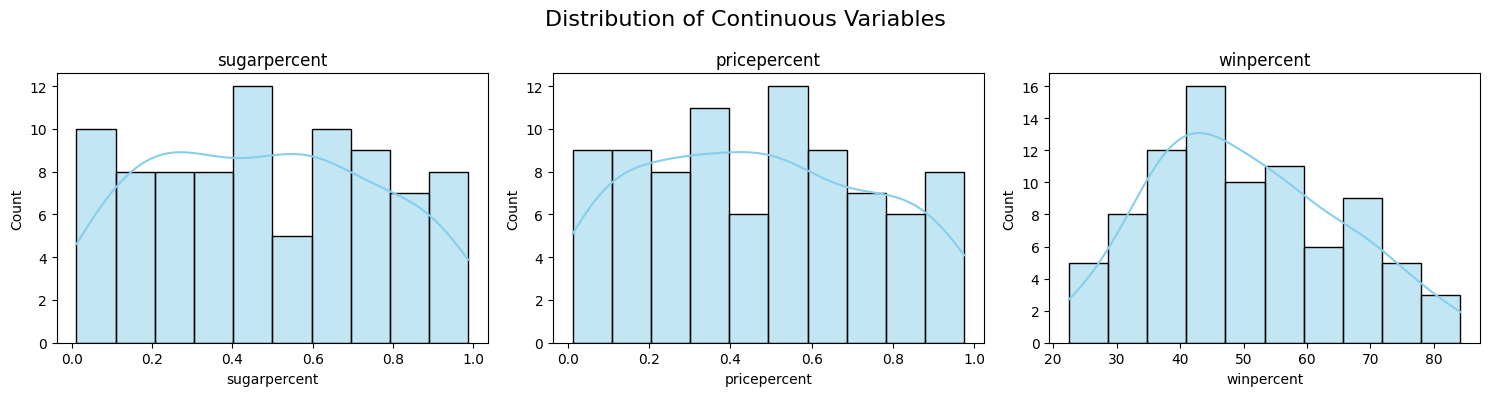

In [9]:
# Plot distributions of continuous variables

# Select continuous columns (float or int, excluding binary/dummy columns)
continuous_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns 
                   if df[col].nunique() > 2] # and col != 'winpercent']

# Plot histograms
vars_to_plot = continuous_cols[:3]  # Select the first three continuous variables

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Distribution of Continuous Variables", fontsize=16)
for i, col in enumerate(vars_to_plot):
    sns.histplot(df[col], ax=axes[i], bins=10, kde=True, color='skyblue')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

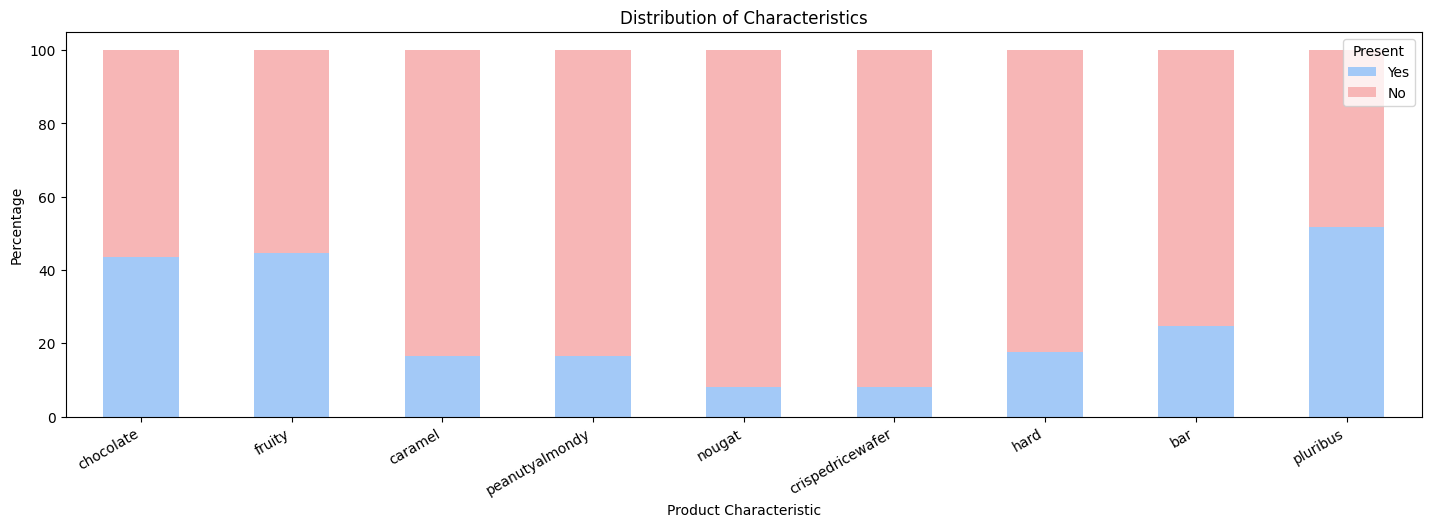

In [10]:
# Plot binary features
binary_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns 
               if set(df[col].dropna().unique()).issubset({0, 1})]

# Calculate value counts as percentages
counts = pd.DataFrame({col: df[col].value_counts(normalize=True).sort_index() * 100 for col in binary_cols}).T

# Reorder columns so 'Yes' (1) is below 'No' (0) in the bar
counts = counts[[1, 0]]
counts.columns = ['Yes', 'No']

# Plot as stacked bars (1 below 0)
ax = counts.plot(kind='bar', stacked=True, color=['#a3c9f7', '#f7b6b6'], figsize=(1.5*len(binary_cols)+4, 5))
ax.set_ylabel('Percentage')
ax.set_xlabel('Product Characteristic')
ax.set_title('Distribution of Characteristics')
plt.xticks(rotation=30, ha='right')
ax.legend(title='Present')

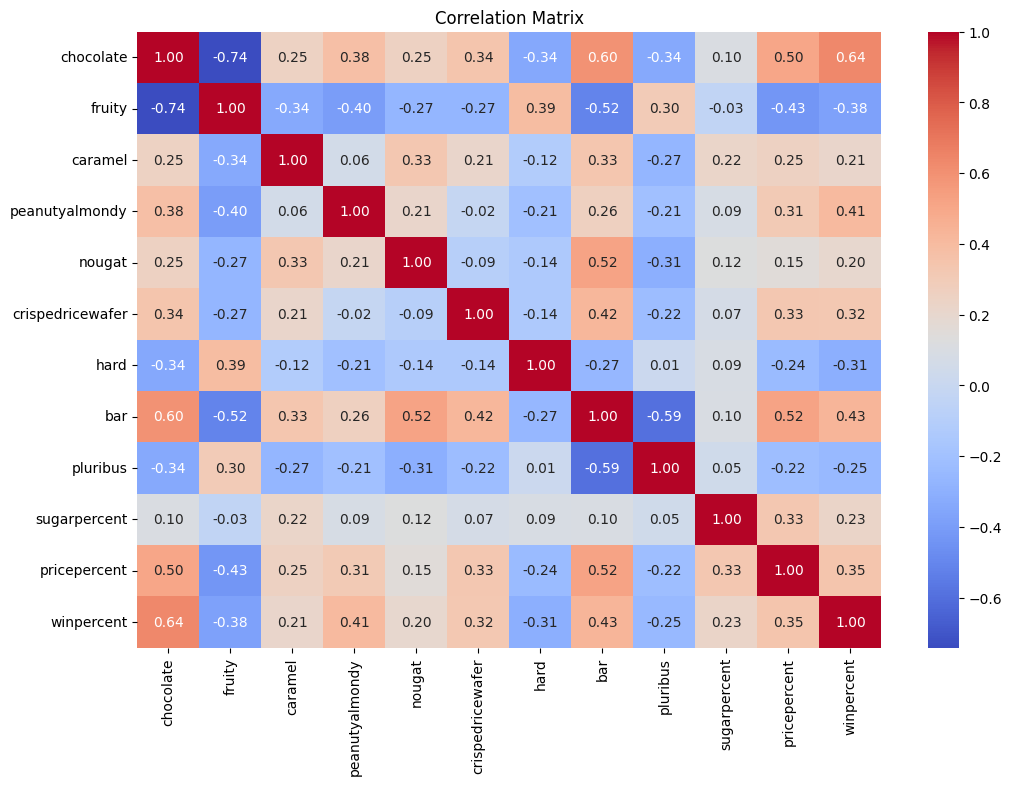

In [11]:
# Correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(data = df.iloc[:, 1:].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

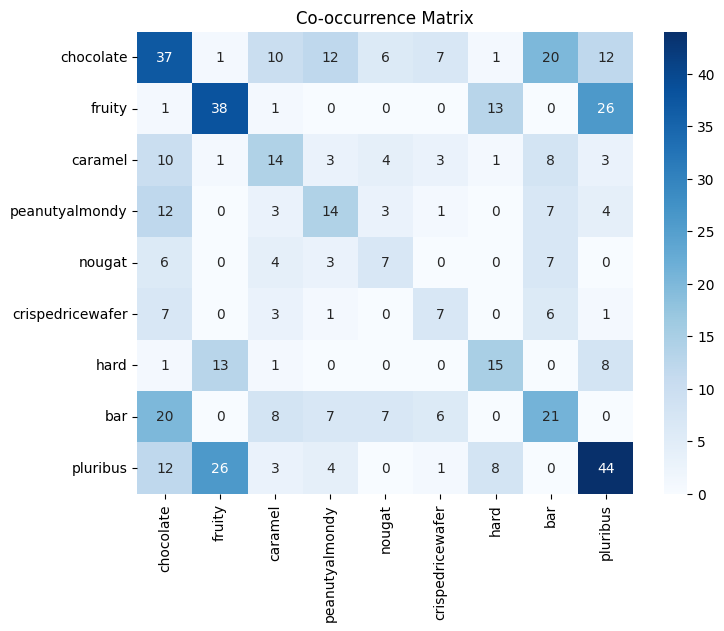

In [12]:
# Co-occurrence Matrix (i.e., the number of times two values are both non-zero)
co_occurrence_matrix = df[binary_cols].T.dot(df[binary_cols])

# Plot the co-occurrence matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='Blues', fmt="d")
plt.title('Co-occurrence Matrix')
plt.show()

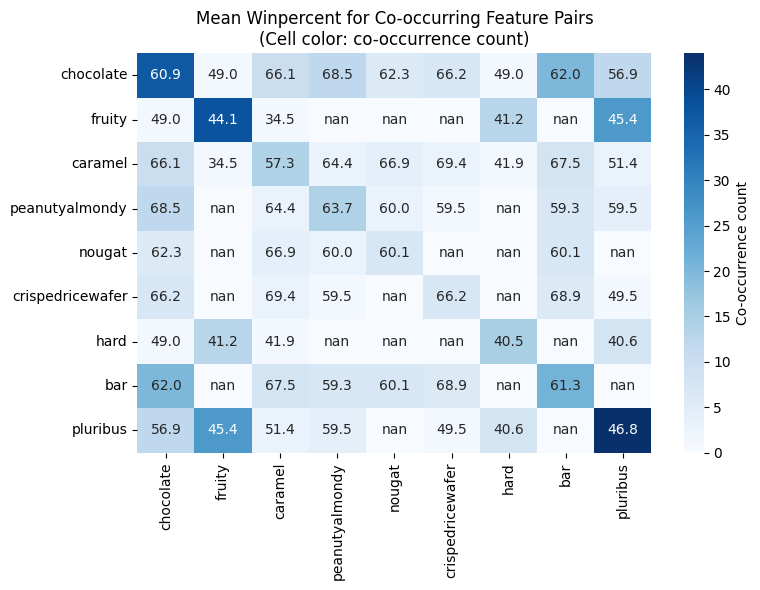

In [13]:
# Compute co-occurrence matrix (number of times two features are both 1)
co_occurrence_matrix = df[binary_cols].T.dot(df[binary_cols])

# Compute mean winpercent for each co-occurring pair
mean_winpercent_matrix = pd.DataFrame(
    np.nan, index=binary_cols, columns=binary_cols
)
for i in binary_cols:
    for j in binary_cols:
        mask = (df[i] == 1) & (df[j] == 1)
        if mask.sum() > 0:
            mean_winpercent_matrix.loc[i, j] = df.loc[mask, 'winpercent'].mean()

# Plot: cell color = co-occurrence count, annotation = mean winpercent
plt.figure(figsize=(8, 6))
sns.heatmap(
    co_occurrence_matrix,
    annot=mean_winpercent_matrix.round(1),
    fmt='.1f',
    cmap='Blues',
    cbar_kws={'label': 'Co-occurrence count'}
)
plt.title('Mean Winpercent for Co-occurring Feature Pairs\n(Cell color: co-occurrence count)')
plt.tight_layout()
plt.show()

### 2. Feature Engineering

In [14]:
# Add brands
brands = pd.read_csv("brands.csv")

# Clean the columns by stripping any extra spaces and normalizing the case
df['competitorname'] = df['competitorname'].str.strip() #.str.lower()
brands['competitorname'] = brands['competitorname'].str.strip()#.str.lower()

# Now merge with df
df = pd.merge(df, brands, on='competitorname', how='left')

# Count of each unique value in the "brand" column
print(df['brand'].value_counts())

# Convert the 'brand' column to dummy variables
df_dummies = pd.get_dummies(df['brand'], prefix='brand', drop_first=False)

# Add the dummies to the dataframe
df = pd.concat([df, df_dummies], axis=1)

brand
Nestlé                   31
Mars                     17
Hershey's                15
Tootsie Roll              8
Haribo                    6
Topps                     2
Wrigley's                 2
Ferrara Candy Company     2
Charms                    1
Jawbusters                1
Name: count, dtype: int64


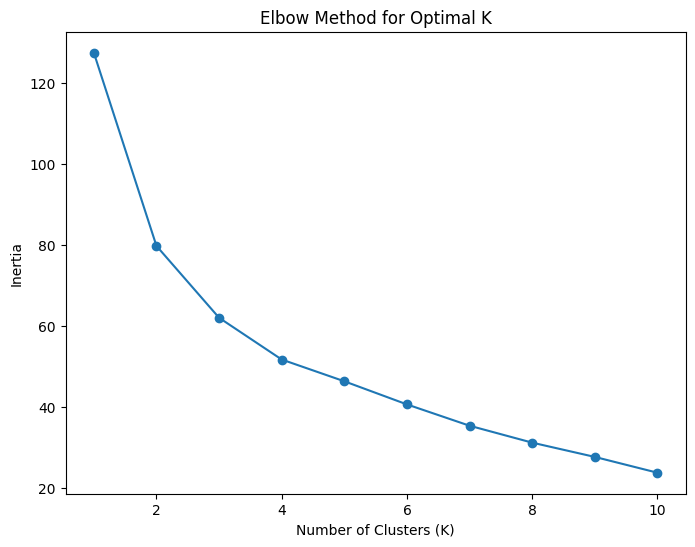

In [15]:
# Cluster treats based on their features
inertia = []

# Try different values of K (from 1 to 10, or any reasonable range)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[binary_cols])
    inertia.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [16]:
# Define the number of clusters (e.g., 3 clusters: chocolate bars, fruity candies, caramel-based)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df[binary_cols])

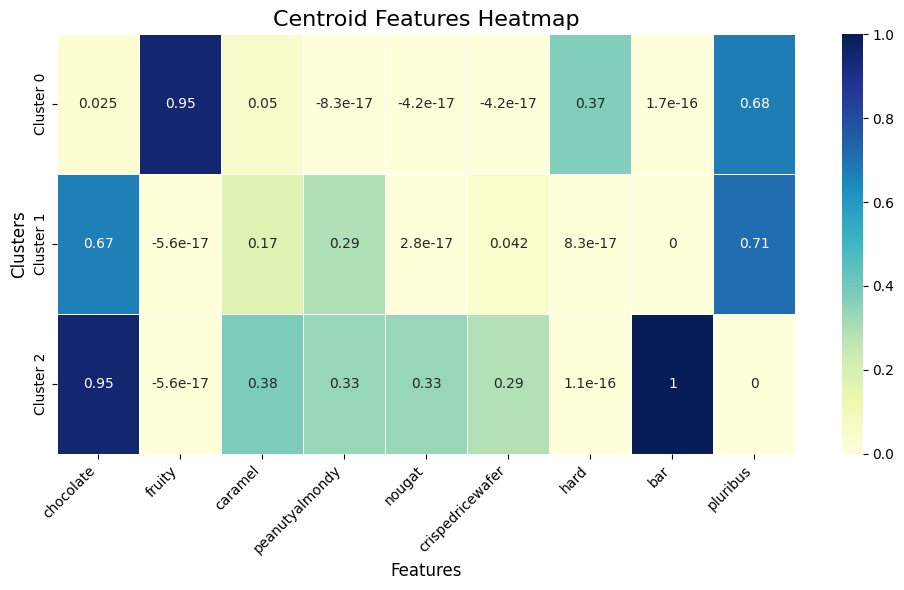

In [17]:
# Inspect cluster centroids
centroids = kmeans.cluster_centers_

# Create a DataFrame with centroids data
df_centroids = pd.DataFrame(centroids, columns=binary_cols, index=[f'Cluster {i}' for i in range(3)])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_centroids, annot=True, cmap='YlGnBu', linewidths=0.5, cbar=True, xticklabels=binary_cols)

# Adding titles and labels
plt.title('Centroid Features Heatmap', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Clusters', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [18]:
# Rename clusters to descriptive names
cluster_names = {0: 'fruit candies', 1: 'pralines', 2: 'chocolate bars'}
df['cluster_name'] = df['cluster'].map(cluster_names)

print(df[['cluster', 'cluster_name']].head())

   cluster    cluster_name
0        2  chocolate bars
1        2  chocolate bars
2        1        pralines
3        1        pralines
4        0   fruit candies


In [19]:
# Convert the 'cluster' column to dummy variables
df_dummies = pd.get_dummies(df['cluster'], prefix='cluster', drop_first=False)

# Add the dummies
df = pd.concat([df, df_dummies], axis=1)

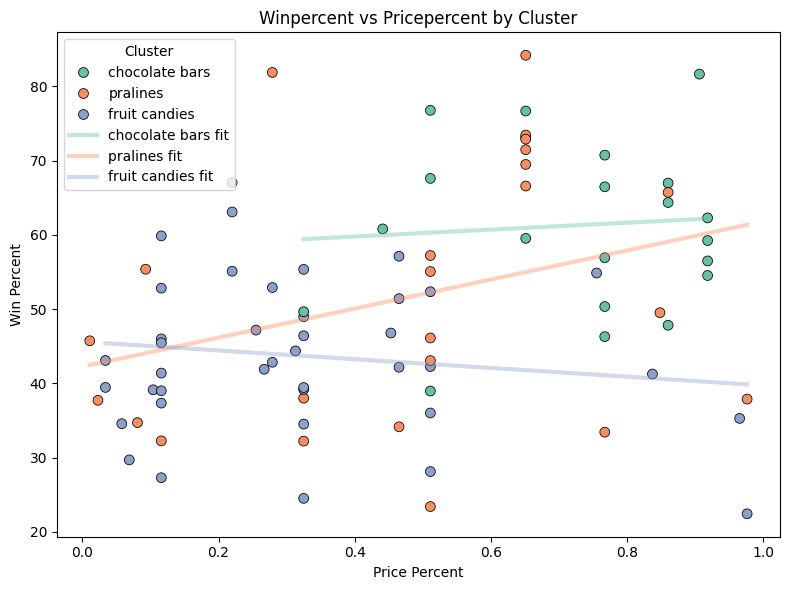

In [20]:
# Scatter plot: winpercent vs pricepercent, colored by cluster_name, with linear fit per cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='pricepercent',
    y='winpercent',
    hue='cluster_name',
    palette='Set2',
    s=50,
    edgecolor='k'
)

# Draw a linear regression line for each cluster, with transparency
for cname, color in zip(df['cluster_name'].unique(), sns.color_palette('Set2')):
    sns.regplot(
        data=df[df['cluster_name'] == cname],
        x='pricepercent',
        y='winpercent',
        scatter=False,
        color=color,
        label=f"{cname} fit",
        ci=None,
        line_kws={'alpha': 0.4, 'lw': 3}
    )

plt.title('Winpercent vs Pricepercent by Cluster')
plt.xlabel('Price Percent')
plt.ylabel('Win Percent')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

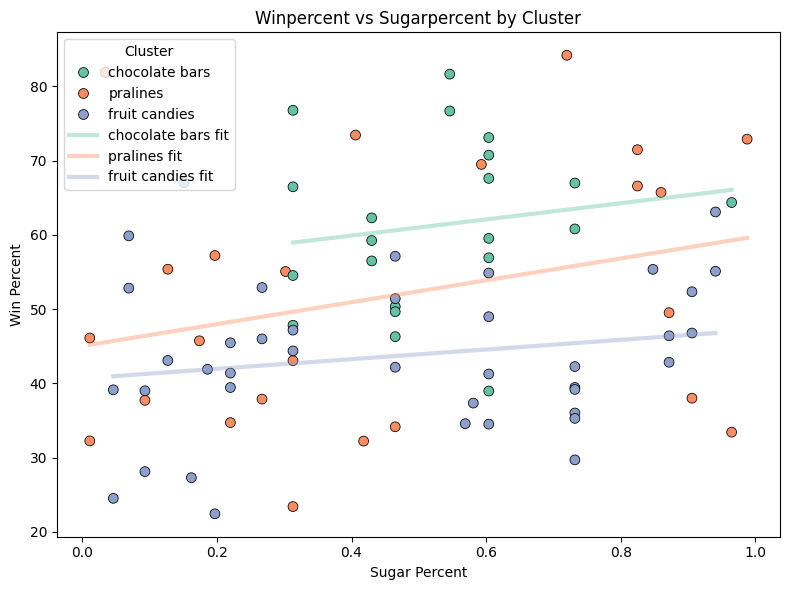

In [21]:
# Scatter plot: winpercent vs pricepercent, colored by cluster_name, with linear fit per cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='sugarpercent',
    y='winpercent',
    hue='cluster_name',
    palette='Set2',
    s=50,
    edgecolor='k'
)

# Draw a linear regression line for each cluster, with transparency
for cname, color in zip(df['cluster_name'].unique(), sns.color_palette('Set2')):
    sns.regplot(
        data=df[df['cluster_name'] == cname],
        x='sugarpercent',
        y='winpercent',
        scatter=False,
        color=color,
        label=f"{cname} fit",
        ci=None,
        line_kws={'alpha': 0.4, 'lw': 3}
    )

plt.title('Winpercent vs Sugarpercent by Cluster')
plt.xlabel('Sugar Percent')
plt.ylabel('Win Percent')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

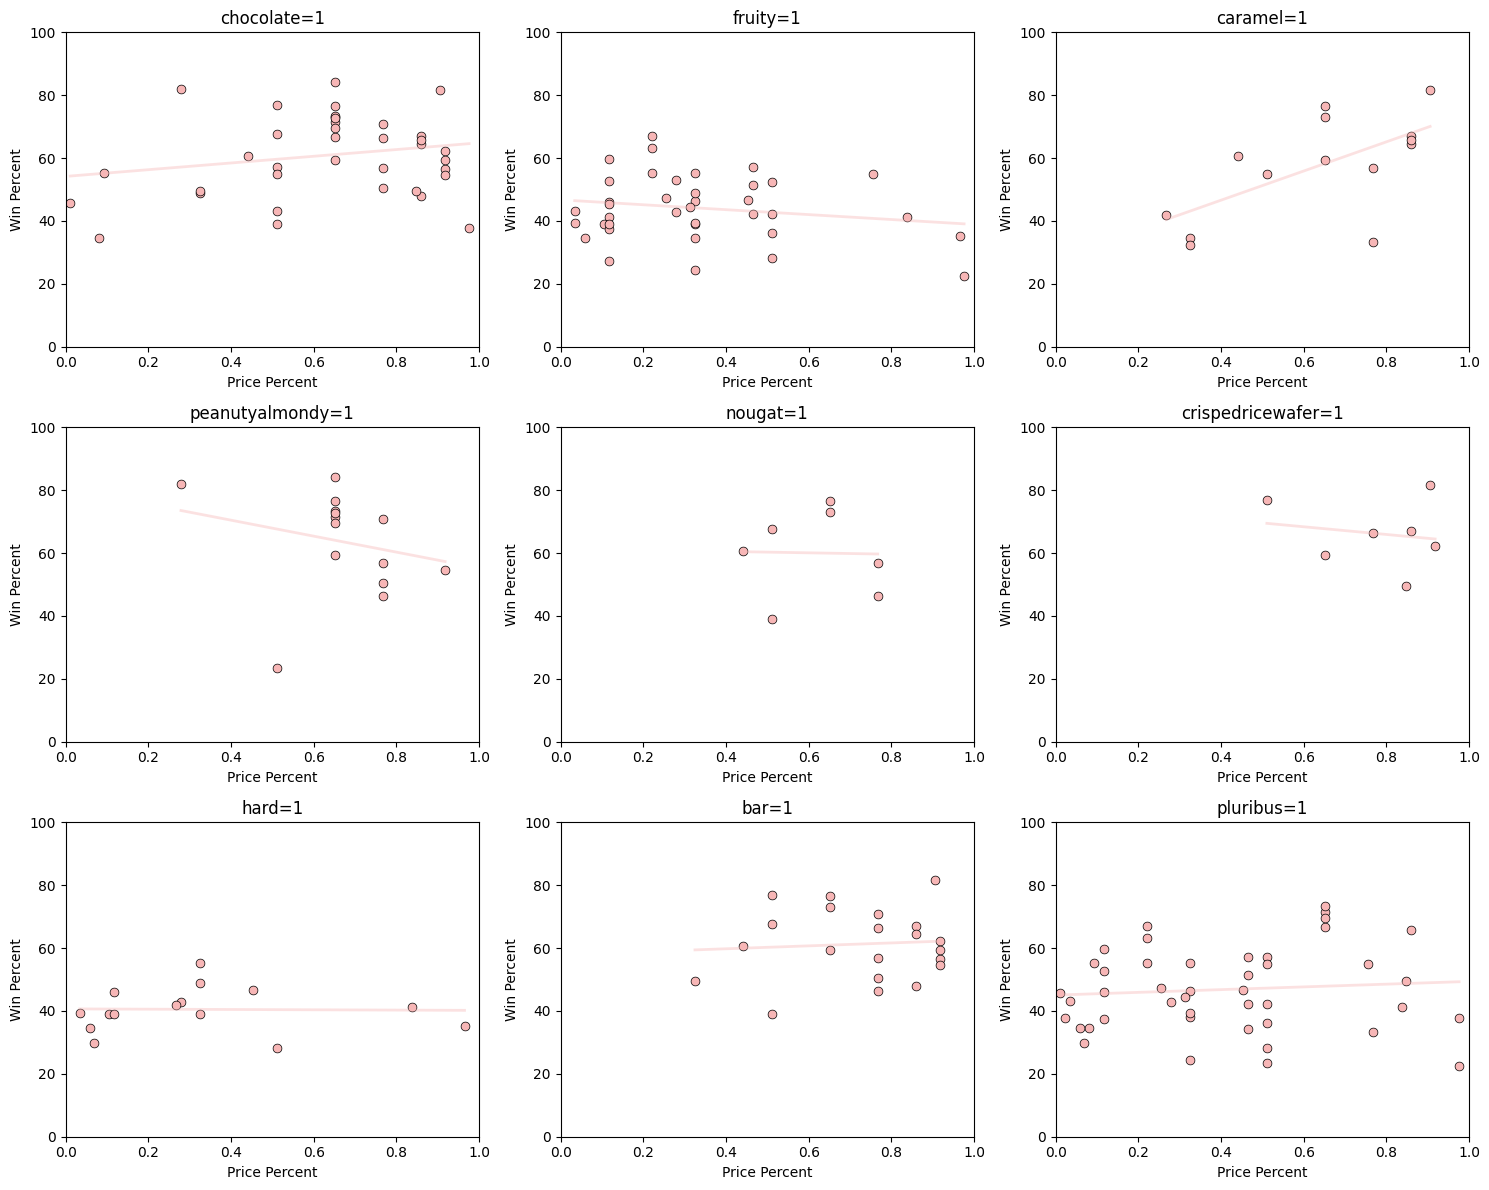

In [22]:
ingredient_cols = [col for col in df.columns if col not in ['competitorname', 'winpercent', 'pricepercent', 'cluster', 'cluster_name'] 
                   and df[col].dropna().isin([0, 1]).all() and not col.startswith('brand_')
                   and not col.startswith('cluster_')]

n = len(ingredient_cols)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
axes = axes.flatten()

for i, ingredient in enumerate(ingredient_cols):
    ax = axes[i]
    df_1 = df[df[ingredient] == 1]
    sns.scatterplot(
        data=df_1,
        x='pricepercent',
        y='winpercent',
        color="#f7b6b6",
        s=40,
        edgecolor='k',
        ax=ax
    )
    sns.regplot(
        data=df_1,
        x='pricepercent',
        y='winpercent',
        scatter=False,
        color="#f7b6b6",
        ci=None,
        line_kws={'alpha': 0.4, 'lw': 2},
        ax=ax
    )
    ax.set_title(f"{ingredient}=1")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 100)
    ax.set_xlabel('Price Percent')
    ax.set_ylabel('Win Percent')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 3. Model Selection

In [23]:
df.columns

Index(['competitorname', 'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
       'pricepercent', 'winpercent', 'brand', 'color', 'brand_ Charms',
       'brand_ Ferrara Candy Company', 'brand_ Haribo', 'brand_ Hershey's',
       'brand_ Jawbusters', 'brand_ Mars', 'brand_ Nestlé',
       'brand_ Tootsie Roll', 'brand_ Topps', 'brand_ Wrigley's', 'cluster',
       'cluster_name', 'cluster_0', 'cluster_1', 'cluster_2'],
      dtype='object')

In [24]:
# Select all columns except those in a given list
exclude_cols = ['competitorname', 'color', 'winpercent', 'brand',
       'brand_ Charms', 'brand_ Ferrara Candy Company', 'brand_ Haribo',
       "brand_ Hershey's", 'brand_ Jawbusters', 'brand_ Mars', 'brand_ Nestlé',
       'brand_ Tootsie Roll', 'brand_ Topps', "brand_ Wrigley's",
       'sugar_price_ratio', 'cluster', 'cluster_name', 'cluster_0',
       'cluster_1', 'cluster_2']
features = [col for col in df.columns if col not in exclude_cols]

X = df[features]
y = df['winpercent']
print('Features:', features)

Features: ['chocolate', 'fruity', 'caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent', 'pricepercent']


In [25]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Support Vector Regressor": SVR(),
    "XGBoost": xgb.XGBRegressor(random_state=42)
}

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store results
results = {}

# Evaluate each model
for model_name, model in models.items():
    # Perform 5-fold cross-validation
    cv_results = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')  # Use MSE for regression
    mse_results = -cv_results  # Since MSE is returned as negative, we negate it

    # Train the model on the full dataset and predict on training data
    model.fit(X, y)
    y_train_pred = model.predict(X)

    # Calculate MSE for training data
    mse_train = mean_squared_error(y, y_train_pred)
    
    # Store results
    results[model_name] = {
        "CV MSE": mse_results.mean(),   # Average CV MSE
        "Train MSE": mse_train          # Training MSE
    }

# Convert results to a DataFrame for easier comparison
results_df = pd.DataFrame(results).T  # Transpose to have models as rows

# Print results
print("Mean Squared Error (MSE) for each model:")
print(results_df)

# Print the average MSE from cross-validation
print("\nAverage Cross-Validated MSE for each model:")
print(results_df["CV MSE"])

# Print the training MSE
print("\nTraining MSE for each model:")
print(results_df["Train MSE"])

Mean Squared Error (MSE) for each model:
                              CV MSE   Train MSE
Linear Regression         131.909874   98.379271
Random Forest             125.532657   23.309732
Support Vector Regressor  181.037636  151.827914
XGBoost                   144.805164    7.196755

Average Cross-Validated MSE for each model:
Linear Regression           131.909874
Random Forest               125.532657
Support Vector Regressor    181.037636
XGBoost                     144.805164
Name: CV MSE, dtype: float64

Training MSE for each model:
Linear Regression            98.379271
Random Forest                23.309732
Support Vector Regressor    151.827914
XGBoost                       7.196755
Name: Train MSE, dtype: float64


In [26]:
# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X, y)

# Predict on training data
y_pred = rf_model.predict(X)

# Calculate MSE for training data
mse = mean_squared_error(y, y_pred)

# Print out the MSE results
print(f"Training MSE: {mse:.4f}")

Training MSE: 23.3097


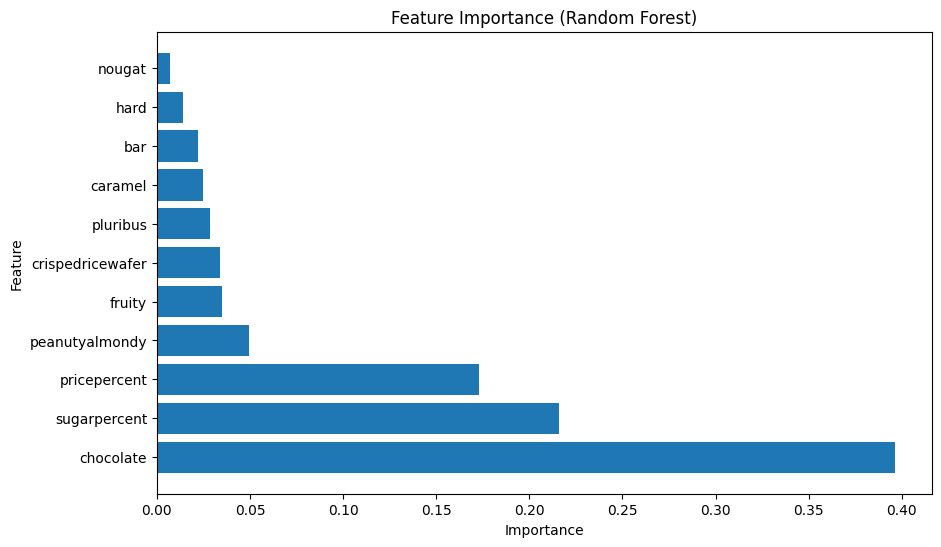

             Feature  Importance
0          chocolate    0.396377
9       sugarpercent    0.215770
10      pricepercent    0.173051
3     peanutyalmondy    0.049678
1             fruity    0.034745
5   crispedricewafer    0.033912
8           pluribus    0.028720
2            caramel    0.024735
7                bar    0.021964
6               hard    0.013964
4             nougat    0.007083


In [27]:
# Assuming your RandomForest model is named 'rf_model'
feature_importances = rf_model.feature_importances_

# Create a DataFrame for easy visualization
feature_names = X.columns  # Feature names from your dataset
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.show()

# Print out the importance values
print(feature_importance_df)


In [29]:
# Prepare KFold (5-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store MSE for each fold (both training and test)
train_mse_values = []
test_mse_values = []

# Cross-validation loop
for train_index, test_index in kf.split(df):
    # Split the data into training and test sets
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
    
    # Fit the mixed-effects model on the training data
    model = mixedlm("winpercent ~ fruity + pricepercent * chocolate + caramel + peanutyalmondy + nougat +  crispedricewafer + hard + bar + pluribus + sugarpercent", train_data, groups=train_data["brand"])
    result = model.fit()
    
    # Get the predictions on the training set
    train_predictions = result.predict(train_data)
    # Get the predictions on the test set
    test_predictions = result.predict(test_data)
    
    # Calculate MSE for training and test data
    train_mse = mean_squared_error(train_data["winpercent"], train_predictions)
    test_mse = mean_squared_error(test_data["winpercent"], test_predictions)
    
    # Append the MSE values to the respective lists
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)
    
    # Print MSE for this fold
    print(f"Fold MSE (Train): {train_mse:.4f}, MSE (Test): {test_mse:.4f}")

# Calculate and print the average MSE across all folds
avg_train_mse = np.mean(train_mse_values)
avg_test_mse = np.mean(test_mse_values)

print(f"\nAverage MSE on Training Data: {avg_train_mse:.4f}")
print(f"Average MSE on Test Data: {avg_test_mse:.4f}")

Fold MSE (Train): 86.8012, MSE (Test): 157.5490
Fold MSE (Train): 95.4424, MSE (Test): 142.1531
Fold MSE (Train): 98.8809, MSE (Test): 116.4719
Fold MSE (Train): 107.9560, MSE (Test): 90.2957
Fold MSE (Train): 90.2689, MSE (Test): 160.5634

Average MSE on Training Data: 95.8699
Average MSE on Test Data: 133.4066


In [30]:
# Example data
np.random.seed(42)

# Fit the mixed-effects model
model = mixedlm("winpercent ~ fruity + pricepercent + chocolate + caramel + peanutyalmondy + nougat +  crispedricewafer + hard + bar + pluribus + sugarpercent", df, groups=df["brand"])
result = model.fit()

# Extract coefficients, standard errors, t-values, and p-values
coefficients = result.fe_params
stderr = result.bse
tvalues = result.tvalues
pvalues = result.pvalues

# Create a DataFrame to display the results
summary_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Std Err': stderr,
    't-value': tvalues,
    'p-value': pvalues
})

# Sort the DataFrame by the absolute value of the coefficients
summary_df['abs_Coefficient'] = summary_df['Coefficient'].abs()
summary_df_sorted = summary_df.sort_values(by='abs_Coefficient', ascending=False)

# Drop the auxiliary 'abs_Coefficient' column for clean output
summary_df_sorted = summary_df_sorted.drop(columns=['abs_Coefficient'])

# Format p-values to avoid scientific notation (e.g., 0.0001 will be shown as 0.0001 instead of 1e-04)
summary_df_sorted['p-value'] = summary_df_sorted['p-value'].apply(lambda x: f'{x:.4f}' if x < 0.0001 else f'{x:.5f}')

# Print the ordered summary with non-scientific p-values
print(summary_df_sorted)

                  Coefficient   Std Err   t-value  p-value
Intercept           33.259504  4.636689  7.173115   0.0000
chocolate           20.732280  3.792973  5.465971   0.0000
fruity              10.572899  3.625212  2.916492  0.00354
peanutyalmondy       9.647351  3.518306  2.742044  0.00611
sugarpercent         8.217881  4.477317  1.835448  0.06644
crispedricewafer     7.494768  4.979785  1.505039  0.13231
pricepercent        -5.617550  5.333588 -1.053240  0.29223
hard                -4.514598  3.426744 -1.317460  0.18768
pluribus            -1.612968  3.025401 -0.533142  0.59394
caramel              1.418347  3.628933  0.390844  0.69591
nougat              -1.031727  5.528191 -0.186630  0.85195
bar                 -0.913671  4.822787 -0.189449  0.84974
Group Var                 NaN  0.213882  1.052150  0.29273
